## Data Preparation and Preprocessing

1. Loading the MID Files
2. Perform Data Augmentation
3. Split Dataset
4. Handle Class Imbalance with WeightedRandomSampler
5. Save the splitted train, test, val sets and loaders to processed_data folder

In [2]:
import os
import torch
from torch.utils.data import DataLoader
from collections import Counter
from data_preprocess_utils import ComposerDataset, SplitData

# Paths and config
DATA_DIR = "midiclassics"  # Path to your Kaggle dataset
COMPOSERS = ["bach", "beethoven", "chopin", "mozart"]
MAX_LENGTH = 500
BATCH_SIZE = 32

# Create output directory
os.makedirs("preprocess_data", exist_ok=True)

## Loading the MID Files

In [3]:
print("Loading dataset...")
dataset = ComposerDataset(
    data_dir=DATA_DIR,
    composers=COMPOSERS,
    max_length=MAX_LENGTH,
    augment=False  # No augmentation yet
)

print(f"\nTotal samples loaded: {len(dataset)}")
print("Class weights:", dataset.class_weights)

labels = [label for (_, label) in dataset.samples]
counts = Counter(labels)

print("\nNumber of compositions per composer:")
for idx, composer in enumerate(COMPOSERS):
    print(f"{composer.capitalize()}: {counts[idx]} MID files")

Loading dataset...


Loading midiclassics\mozart: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [01:01<00:00,  4.21it/s]



Total samples loaded: 1529
Class weights: tensor([0.0634, 0.2765, 0.4311, 0.2290])

Number of compositions per composer:
Bach: 925 MID files
Beethoven: 212 MID files
Chopin: 136 MID files
Mozart: 256 MID files


## Visualize the Data

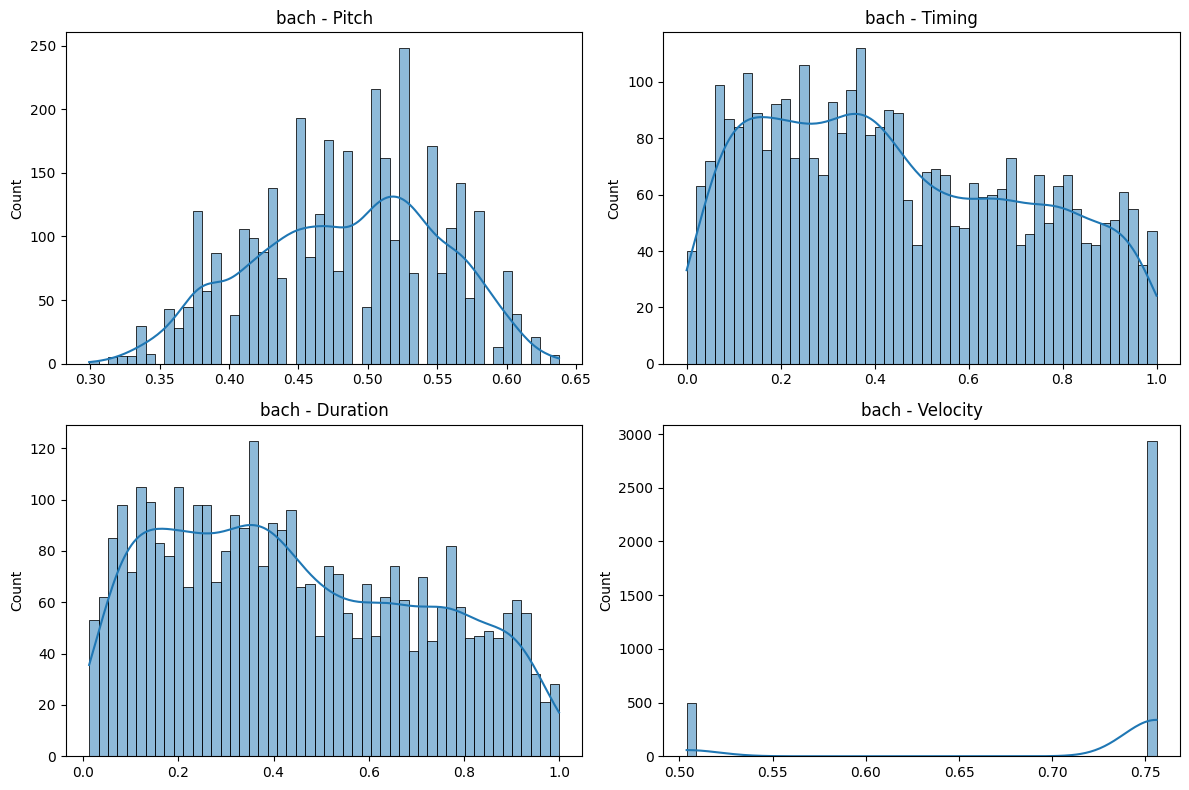

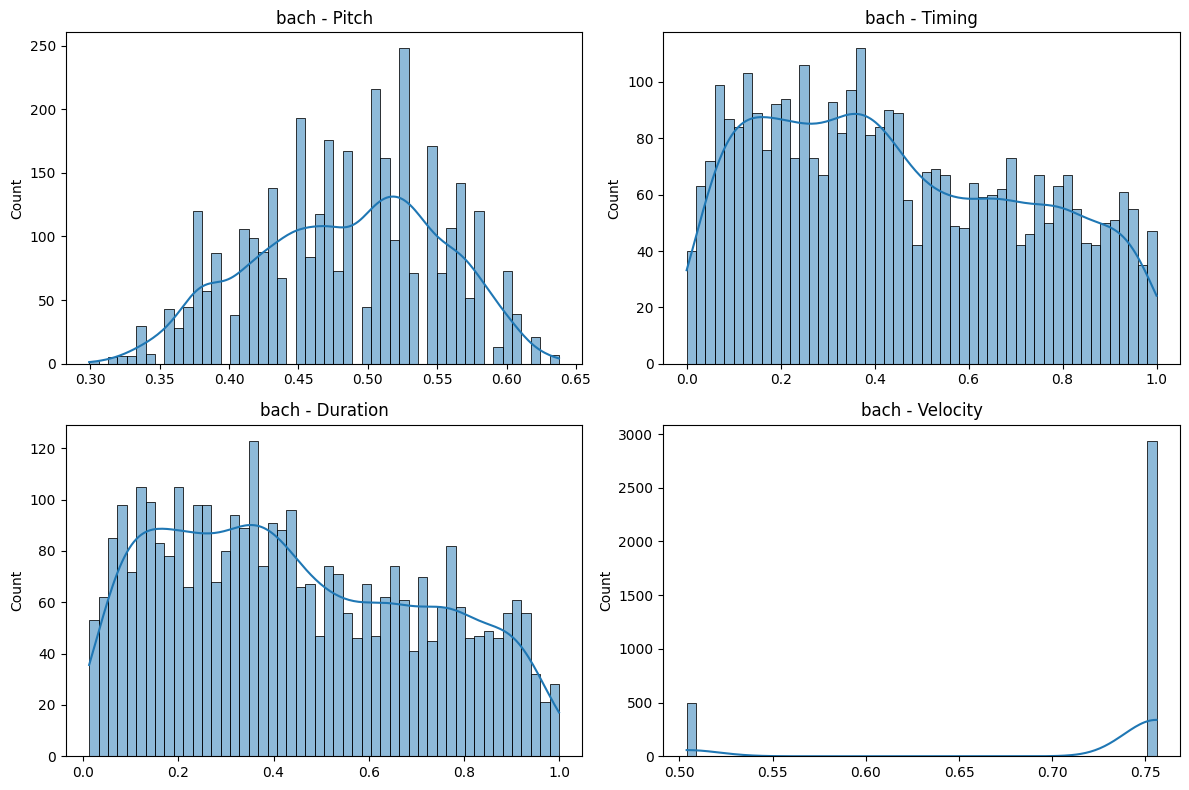

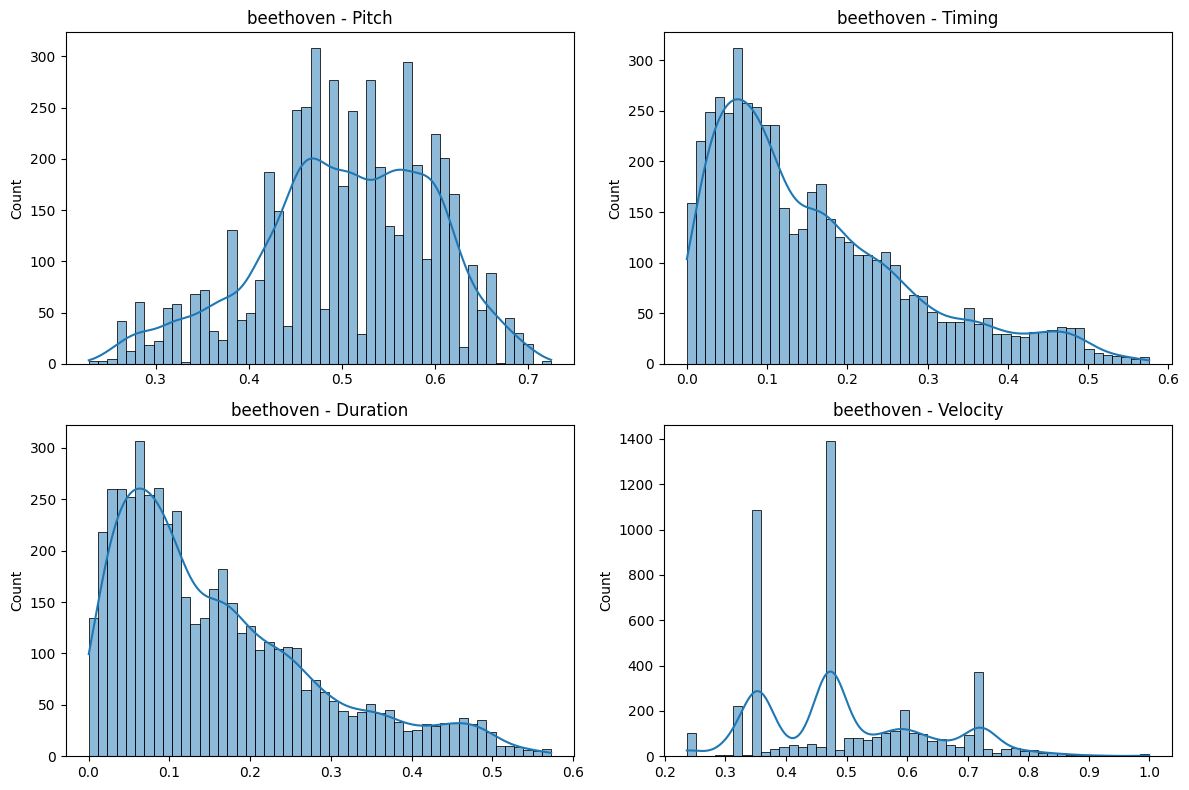

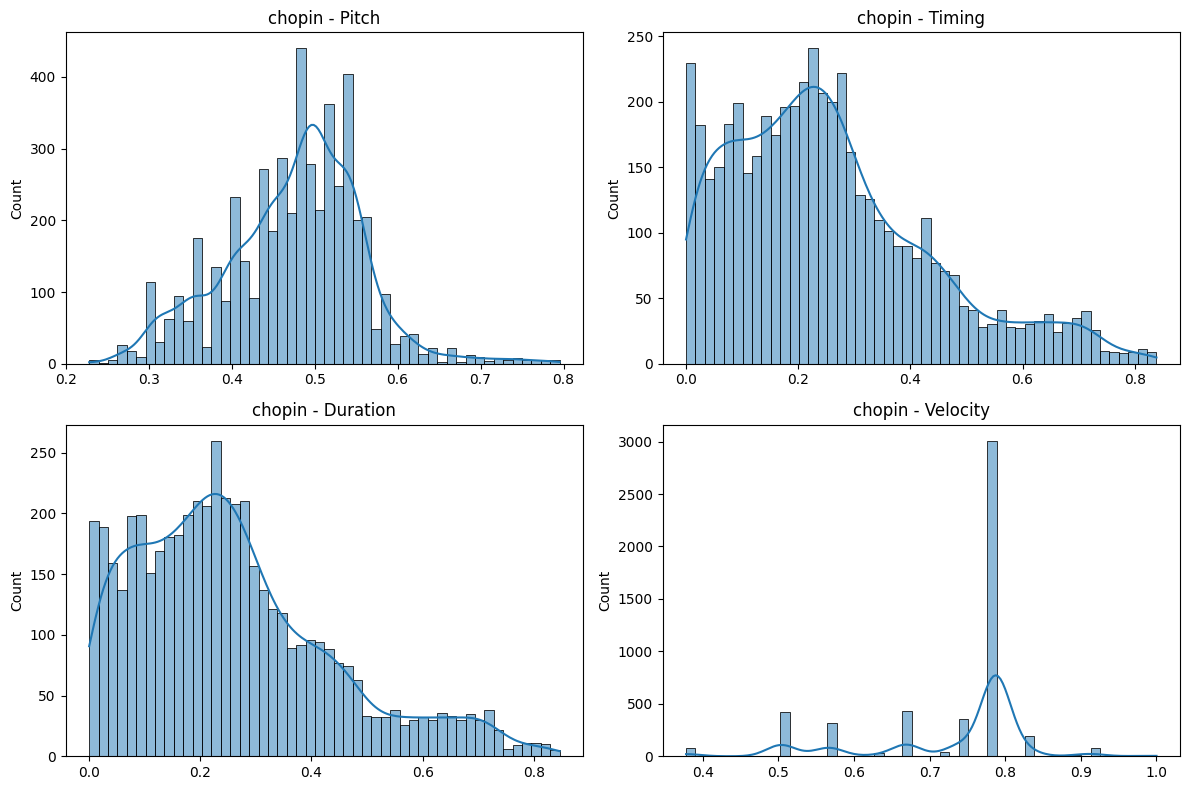

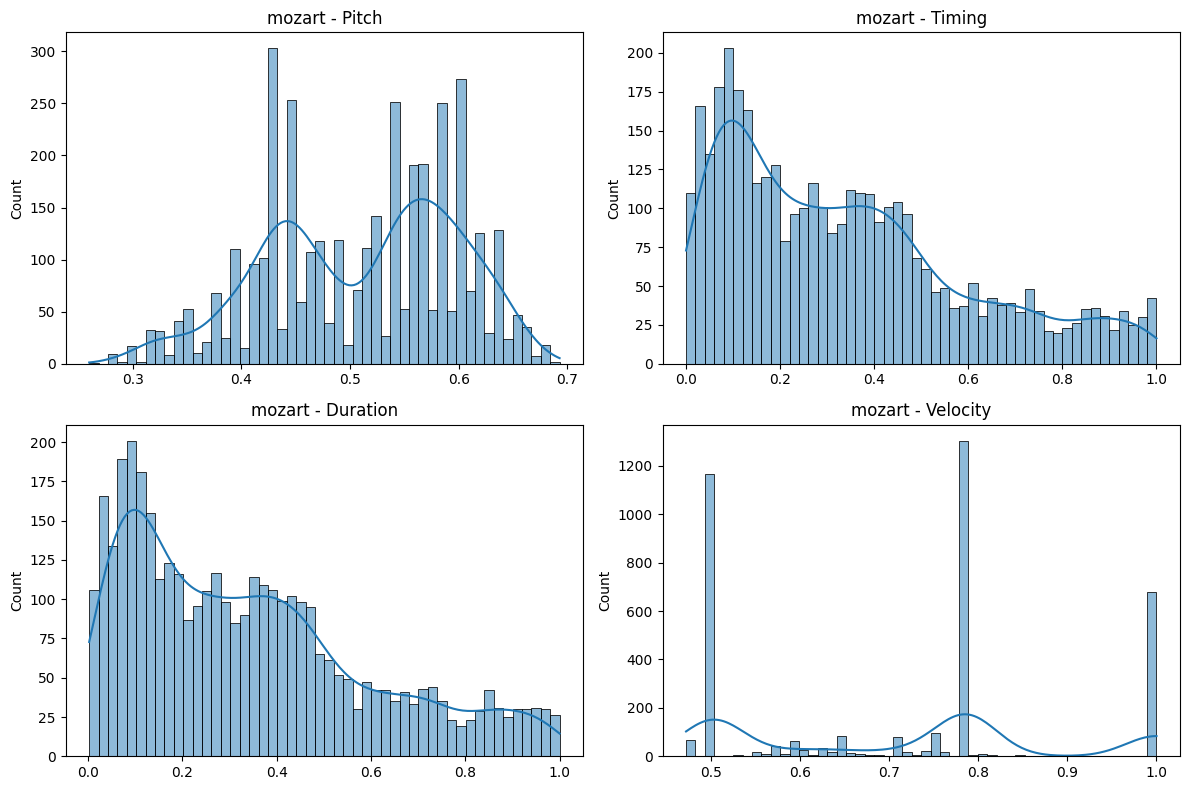

In [4]:
from data_preprocess_utils import SplitData

splitter = SplitData(dataset)

# Visualize first composer's features
splitter.plot_feature_distribution(composer_idx=0, max_samples=10)

# Optional: visualize all composers
for i, composer in enumerate(COMPOSERS):
    splitter.plot_feature_distribution(composer_idx=i, max_samples=10)

## Perform Data Augmentation

Loading midiclassics\mozart: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:57<00:00,  4.50it/s]


Samples after augmentation (on the fly): 1529

Number of compositions per composer:
Bach: 925 MID files
Beethoven: 212 MID files
Chopin: 136 MID files
Mozart: 256 MID files


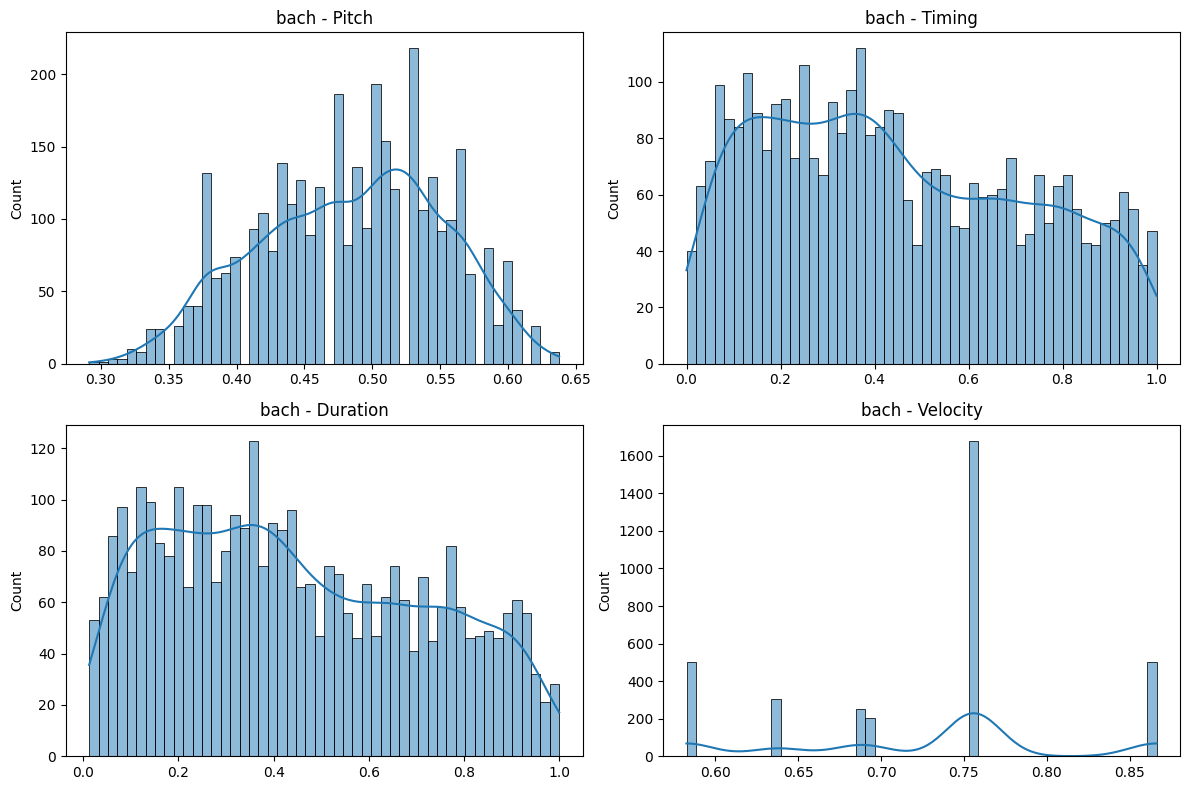

In [5]:
from data_preprocess_utils import MidiAugmenter

augment_dataset = ComposerDataset(
    data_dir=DATA_DIR,
    composers=COMPOSERS,
    max_length=MAX_LENGTH,
    augment=True  # Enable random augmentation
)

print(f"Samples after augmentation (on the fly): {len(augment_dataset)}")

# Visualize augmented features for Bach
splitter_aug = SplitData(augment_dataset)

labels = [label for (_, label) in augment_dataset.samples]
counts = Counter(labels)

print("\nNumber of compositions per composer:")
for idx, composer in enumerate(COMPOSERS):
    print(f"{composer.capitalize()}: {counts[idx]} MID files")
splitter_aug.plot_feature_distribution(composer_idx=0, max_samples=10)


## Split Dataset

In [6]:
train_set, val_set, test_set = splitter.create_stratified_splits(
    test_size=0.2, val_size=0.1
)

splitter.print_split_stats(train_set, "train")
splitter.print_split_stats(val_set, "val")
splitter.print_split_stats(test_set, "test")


TRAIN SET CLASS DISTRIBUTION:
- Bach: 648 samples
- Beethoven: 148 samples
- Chopin: 95 samples
- Mozart: 179 samples

VAL SET CLASS DISTRIBUTION:
- Bach: 92 samples
- Beethoven: 21 samples
- Chopin: 14 samples
- Mozart: 26 samples

TEST SET CLASS DISTRIBUTION:
- Bach: 185 samples
- Beethoven: 43 samples
- Chopin: 27 samples
- Mozart: 51 samples


## Handle the Class Imbalance with `WeightedRandomSampler`

In [7]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Compute sample weights for the training set
labels = [dataset.samples[i][1] for i in train_set.indices]  # labels of train samples
class_weights = dataset.class_weights  # Already computed in ComposerDataset

# Map class weight to each sample
sample_weights = [class_weights[label].item() for label in labels]

# Create the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # sample as many as the training set
    replacement=True  # allow oversampling
)


In [8]:
BATCH_SIZE = 32

# Training loader with weighted sampling
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    sampler=sampler  # weighted sampler here
)

# Validation and Test use normal sequential sampling
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Check one batch
batch = next(iter(train_loader))
print("Features shape:", batch['features'].shape)
print("Labels in batch:", batch['label'])


Features shape: torch.Size([32, 500, 4])
Labels in batch: tensor([0, 1, 1, 2, 3, 0, 3, 3, 2, 3, 1, 0, 0, 2, 3, 1, 2, 2, 0, 3, 2, 3, 0, 1,
        0, 1, 3, 3, 0, 2, 1, 3])


In [9]:
import collections

indices = list(WeightedRandomSampler(sample_weights, 500, replacement=True))
balanced_labels = [labels[i] for i in indices]
print("Simulated balanced distribution:", collections.Counter(balanced_labels))

Simulated balanced distribution: Counter({3: 150, 0: 121, 2: 119, 1: 110})


## Saving the files

In [13]:
import torch

def save_tensor_dataset(dataset, save_path):
    features, lengths, labels = [], [], []

    for sample in dataset:
        features.append(sample['features'])
        lengths.append(sample['length'])
        labels.append(sample['label'])
    
    torch.save({
        "features": torch.stack(features),
        "lengths": torch.stack(lengths),
        "labels": torch.stack(labels)
    }, save_path)

# Save for all splits
save_tensor_dataset(train_set, "processed_data/train_data.pt")
save_tensor_dataset(val_set, "processed_data/val_data.pt")
save_tensor_dataset(test_set, "processed_data/test_data.pt")

print("Compact tensor datasets saved for team use.")

Compact tensor datasets saved for team use.
